# Inspeccionando Vectores de Palabras

In [2]:
import os
!pip install fasttext
import fasttext
import numpy as np
import matplotlib.pyplot as plt


if not os.path.exists("cc.es.300.bin"):
  # Más vectores de palabras en https://github.com/dccuchile/spanish-word-embeddings
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
  !gzip -d cc.es.300.bin.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.9 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3160701 sha256=d93eea811d0becee2a386307c5dc3e41abfd9488418346d43622b4330852c248
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
--2022-09-27 11:40:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500107671 (4.2G) [application/octet-stream]
Saving to: ‘cc.es.300.bin.gz’

cc.es.300.bin.gz    100%[===================>]   4.19G  47.7

Vamos a usar la librería [FastText](https://fasttext.cc/) para cargar las representaciones pre-entrenadas. En particular usaremos los vectores preentrenados sobre [Common Crawl](https://commoncrawl.org/) y [Wikipedia](https://www.wikipedia.org/). Los mismos pueden descargarse de la [página de FastText](https://fasttext.cc/docs/en/crawl-vectors.html#models), en donde hay modelos pre-entrenados para 157 idiomas diferentes.

En primer lugar, usamos la función `load_model` de FastText para cargar el modelo en memoria. Para nostres, el objeto `model` va a funcionar como un diccionario de pares "palabra-numpy.array" que devuelve un vector para cada palabra contenida en él.

**Nota**: FastText maneja automáticamente las palabras que no se encuentran en el vocabulario haciendo uso de las sub-palabras. Esta práctica se extiende un poco de lo visto en la teórica pero para más información se recomienda leer el paper original [(Bojanowski et al., 2016)](https://arxiv.org/abs/1607.04606).

In [3]:
model = fasttext.load_model('cc.es.300.bin')

Una vez cargado el modelo, definimos las palabras que queremos usar y las cargamos todas como filas de una matriz.

In [4]:
# words_to_be_plotted = [
#   # infinitivo a gerundio
#   "jugar", "jugando", "cantar", "cantando", "ser", "siendo", "leer", "leyendo",
#   # infinitivo a pretérito perfecto simple
#   "temer", "temió", "andar", "anduvo", "querer", "quiso", "dormir", "durmió", "ver", "vio",
#   # Infinitivo a participio
#   "soñar", "soñado", "hacer", "hecho", "estar", "estado", "ganar", "ganado"
# ]

words_to_be_plotted = [
  # Antónimos
  "decidido", "indeciso", "eficiente", "ineficiente", "probable", "improbable", "racional", "irracional",
  "honesto", "deshonesto", "sabido", "desconocido", "agradable", "desagradable", "productivo", "improductivo"
  # Género
  "decidida", "indecisa", "honesta", "deshonesta", "sabida", "desconocida", "productiva", "improductiva"
]

#words_to_be_plotted = [
#  # Gentilicio
#  "Argentina", "argentino", "argentina", "Brasil", "brasilero", "brasilera", "España", "español", "española", 
#  "Colombia", "colombiano", "colombiana", "Francia", "francés", "francesa", "Canadá", "canadiense", "canadiensa"
  # Calificaciones
#  "bueno", "buena", "malo", "mala", "feo", "fea", "terrible", "espléndido", "espléndida"
#]

# Obtenemos la matriz de word embeddings
word_embeddings_matrix = np.vstack([model[word] for word in words_to_be_plotted])
print("Matrix shape:",word_embeddings_matrix.shape)

Matrix shape: (23, 300)


Calculo las componentes principales. Para calcular que esta representación sea interpretada como los ejes principales, las muestras deben estar centradas por su media.

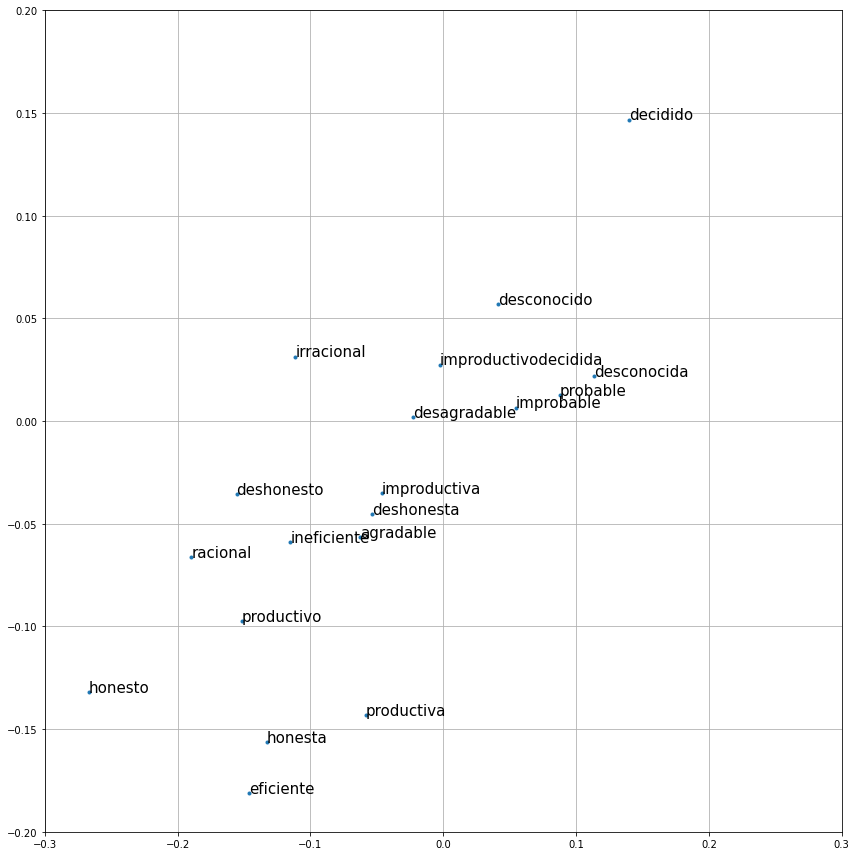

In [6]:
from sklearn import decomposition

def plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim=None,y_lim=None):
  """
  Función para graficar los vectores en dos dimensiones.

  Args:
    - word_embeddings_matrix: numpy.array de dimensión (n x d) con las
    representaciones de las palabras. (n = cantidad de palabras, d = dimensión
    de los vectores.)
    - words_to_be_plotted: lista de palabras correspondientes a las filas de la 
    matriz word_embeddings_matrix.
    - x_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje x.
    - y_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje y.

  """

  # Extraigo las primeras 2 componentes principales
  pca = decomposition.PCA(n_components=2)
  pca.fit(word_embeddings_matrix)
  principals = pca.transform(word_embeddings_matrix)

  # Si los límites son None, los seteo para inluir a todas las representaciones.
  if not x_lim:
    x_lim = (principals[:,0].min()*1.1, principals[:,0].max()*1.1)
  if not y_lim:
    y_lim = (principals[:,1].min()*1.1, principals[:,1].max()*1.1)

  # Grafico los puntos
  fig, ax = plt.subplots(1,1,figsize=(12,12))
  ax.plot(principals[:,0],principals[:,1],"o",ms=3)

  # Anoto las palabras
  for i, word in enumerate(words_to_be_plotted):
    if principals[i,0] <= x_lim[0] or principals[i,1] <= y_lim[0] or \
      principals[i,0] >= x_lim[1] or principals[i,1] >= y_lim[1]:
        continue
    ax.text(principals[i,0]*1.001,principals[i,1]*1.001,word,fontsize=15)

  ax.grid(True)
  ax.set_xlim(*x_lim)
  ax.set_ylim(*y_lim)
  fig.tight_layout()


x_lim = (-0.3,0.3)
y_lim = (-0.2,0.2)
plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim,y_lim)